<a href="https://colab.research.google.com/github/EmiTR/Testprojekt-ET/blob/main/ET_MNIST_GAN_ContentFehlt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will implement Generative Adversarial Nets (GAN) from [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf). 

The dataset I use for this notebook and for other GAN-notebooks is MNIST (Modified National Institute of Standards and Technology) of handwritten digits in black and white.

To use GPU for this notebook in Colab: Runtime -> Change Runtime Type -> GPU

# Setup

In [1]:
# Packages for GAN
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision

# Supporting packages
import os
import numpy as np
import math
import sys
from time import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
os.makedirs("images", exist_ok=True)

In [2]:
# Not really necessary but neat
class Opt(object):
    dim = 10
    n_epochs = 200
    batch_size = dim*dim
    lr = 0.0002
    b1 = 0.5
    b2 = 0.999
    n_cpu = 1
    latent_dim = 100
    img_size = 28
    channels = 1
    sample_interval = 400
opt = Opt() 
img_shape = (opt.channels, opt.img_size, opt.img_size)

In [3]:
#checking cuda
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Input noise vector

# Generator Model

**Each layer of generator:**

*   Fully connected with other layers
*   Uses Linear(input, output) and LeakyReLU(0.2, inplace=True)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

# Discriminator Model

**Each layer of discriminator:**


*   Convolution for downsampling
*   Use batchnorm except for the last layer
*   Apply LeakyReLU activation with slope of 0.2 for all layers 




In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Start Training

In [9]:
bce_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()
#If I ever have cuda..
if torch.cuda:
    generator.cuda()
    discriminator.cuda()
    bce_loss.cuda()

In [10]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



In [11]:
# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
 
Tensor = torch.cuda.FloatTensor if torch.cuda else torch.FloatTensor

In [12]:
saved_imgs = []
for epoch in range(opt.n_epochs):
    print('Epoch ' + str(epoch) + ' training...' , end=' ')
    start = time()
    for i, (imgs, _) in enumerate(dataloader):
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(imgs.type(Tensor))
        #  train Generator
        generator_optimizer.zero_grad()
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        # generate a batch of images
        gen_imgs = generator(z)
        # loss measures generator's ability to fool the discriminator:
        # for the generated images, the generator wants the discriminator to think they're real (1)
        # so if the discriminator(gen_imgs) == real == 1, then the generator is doing a good job, there is no loss
        generator_loss = bce_loss(discriminator(gen_imgs), real)
        generator_loss.backward()
        generator_optimizer.step()
        # train Discriminator
        discriminator_optimizer.zero_grad()
        # loss measure discriminator's ability to classify real from generated samples:
        real_loss = bce_loss(discriminator(real_imgs),         real)
        fake_loss = bce_loss(discriminator(gen_imgs.detach()), fake)
        discriminator_loss = (real_loss + fake_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()
        batches_done = epoch * len(dataloader) + i
    end = time()
    elapsed = end - start
    print('done, took %.1f seconds.' % elapsed)
    grid = torchvision.utils.make_grid(gen_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    saved_imgs.append(img)

Epoch 0 training... done, took 11.2 seconds.
Epoch 1 training... done, took 11.0 seconds.
Epoch 2 training... done, took 11.3 seconds.
Epoch 3 training... done, took 11.3 seconds.
Epoch 4 training... done, took 11.2 seconds.
Epoch 5 training... done, took 11.3 seconds.
Epoch 6 training... done, took 11.3 seconds.
Epoch 7 training... done, took 11.2 seconds.
Epoch 8 training... done, took 11.3 seconds.
Epoch 9 training... done, took 11.4 seconds.
Epoch 10 training... done, took 11.4 seconds.
Epoch 11 training... done, took 11.2 seconds.
Epoch 12 training... done, took 11.2 seconds.
Epoch 13 training... done, took 11.4 seconds.
Epoch 14 training... done, took 11.3 seconds.
Epoch 15 training... done, took 11.6 seconds.
Epoch 16 training... done, took 11.2 seconds.
Epoch 17 training... done, took 11.2 seconds.
Epoch 18 training... done, took 11.3 seconds.
Epoch 19 training... done, took 11.2 seconds.
Epoch 20 training... done, took 11.1 seconds.
Epoch 21 training... done, took 11.3 seconds

# Visualization

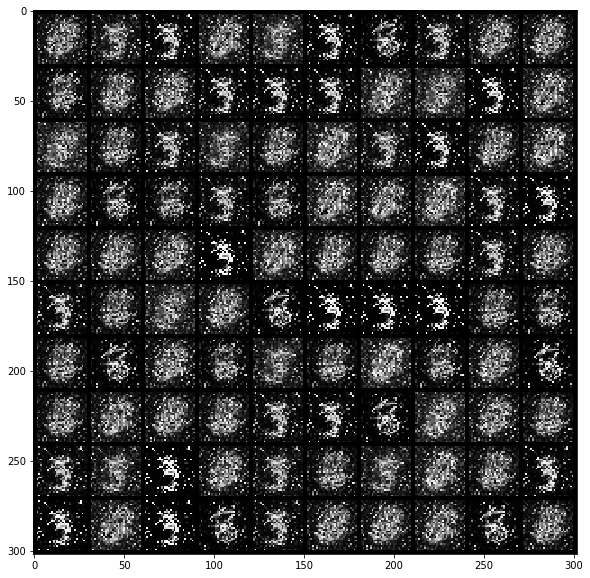

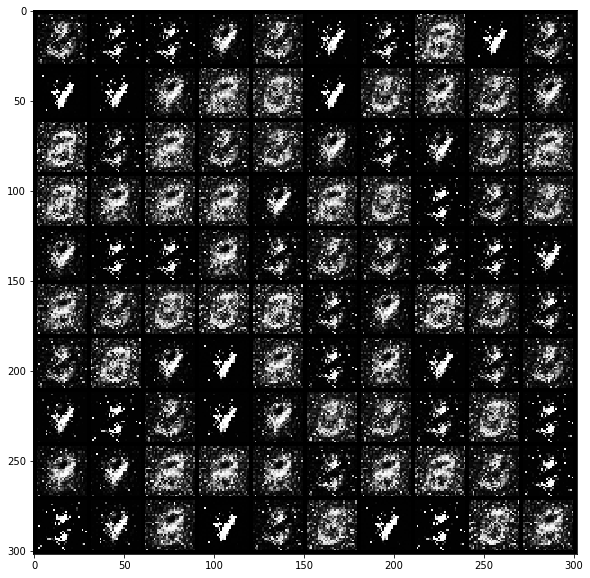

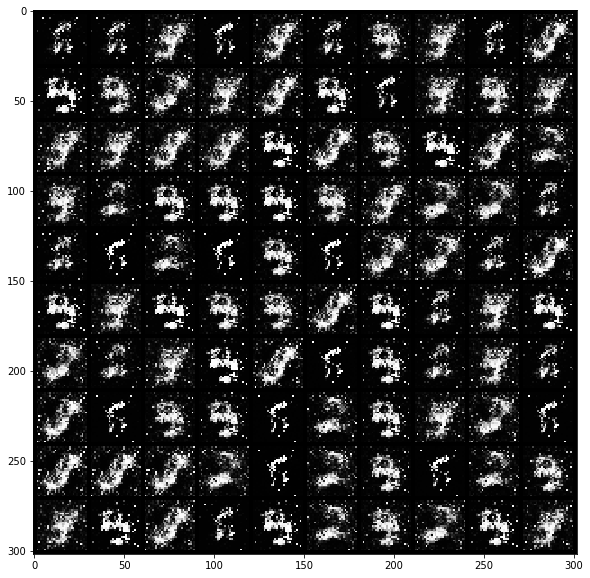

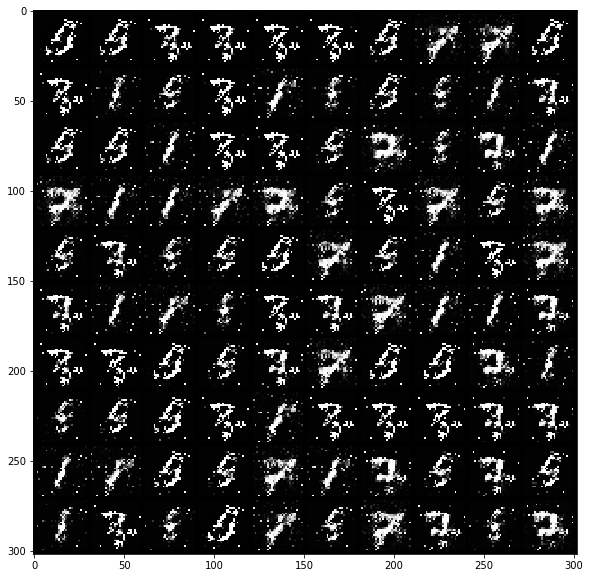

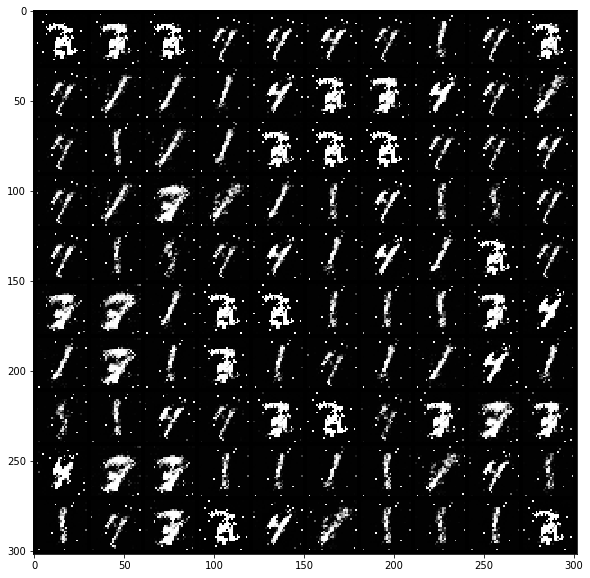

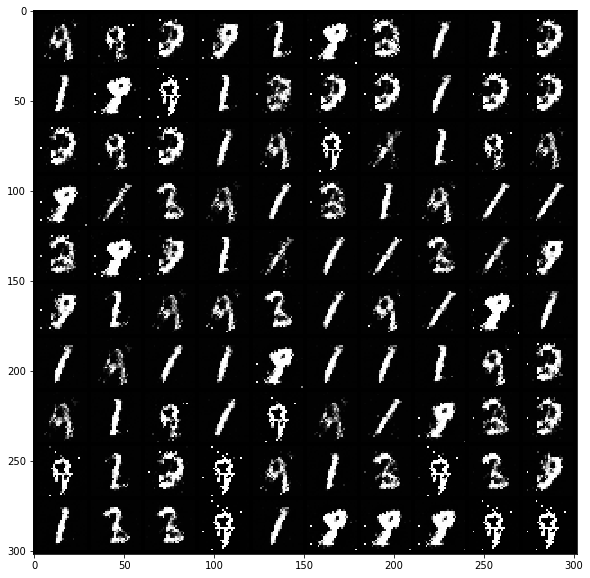

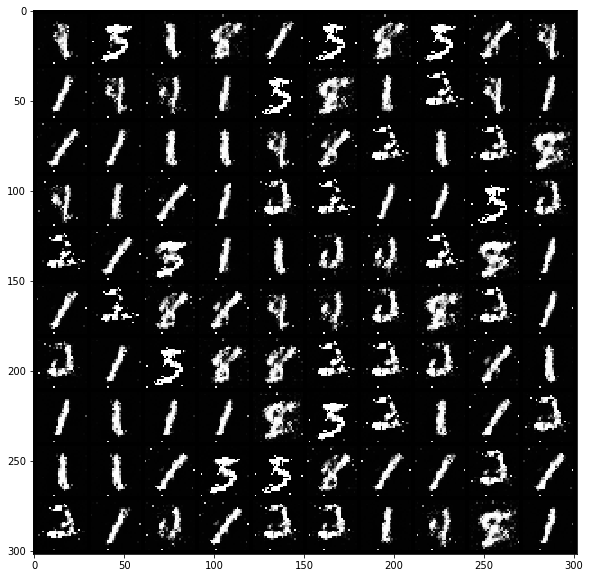

In [13]:
img_indexes = [0, 4, 9, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))
    plt.imshow(saved_imgs[i], interpolation='nearest')

# What's next
